In [7]:
import os
import json
import time
import pickle
import requests
import time
import warnings
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import io, s3fs
pd.set_option('display.max_columns', None)


# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances


In [8]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
pct = pd.read_csv('s3://bleeding-hearts/workingdata/merge_pct.csv')

In [33]:
est.isnull()


,Unnamed: 0,EMPLOYMENT STATUS_Population 16 years and over,EMPLOYMENT STATUS_Population 16 years and over_In labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces,EMPLOYMENT STATUS_Population 16 years and over_Not in labor force,EMPLOYMENT STATUS_Civilian labor force,EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate,EMPLOYMENT STATUS_Females 16 years and over,EMPLOYMENT STATUS_Females 16 years and over_In labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Own children of the householder under 6 years,EMPLOYMENT STATUS_Own children of the householder under 6 years_All parents in family in labor force,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years_All parents in family in labor force,COMMUTING TO WORK_Workers 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone","COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- carpooled",COMMUTING TO WORK_Workers 16 years and over_Public transportation (excluding taxicab),COMMUTING TO WORK_Workers 16 years and over_Walked,COMMUTING TO WORK_Workers 16 years and over_Other means,COMMUTING TO WORK_Workers 16 years and over_Worked at home,COMMUTING TO WORK_Mean travel time to work (minutes),OCCUPATION_Civilian employed population 16 years and over,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",OCCUPATION_Civilian employed population 16 years and over_Service occupations,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations","OCCUPATION_Civilian employed population 16 years and over_Production, transportation, and material moving occupations",INDUSTRY_Civilian employed population 16 years and over,"INDUSTRY_Civilian employed population 16 years and over_Agriculture, forestry, fishing and hunting, and mining",INDUSTRY_Civilian employed population 16 years and over_Construction,INDUSTRY_Civilian employed population 16 years and over_Manufacturing,INDUSTRY_Civilian employed population 16 years and over_Wholesale trade,INDUSTRY_Civilian employed population 16 years and over_Retail trade,"INDUSTRY_Civilian employed population 16 years and over_Transportation and warehousing, and utilities",INDUSTRY_Civilian employed population 16 years and over_Information,"INDUSTRY_Civilian employed population 16 years and over_Finance and insurance, and real estate and rental and leasing","INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","INDUSTRY_Civilian employed population 16 years and over_Educational services, and health care and social assistance","INDUSTRY_Civilian employed population 16 years and over_Arts, entertainment, and recreation, and accommodation and food services","INDUSTRY_Civilian employed population 16 years and over_Other services, except public administration",INDUSTRY_Civilian employed population 16 years and over_Public administration,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,CLASS OF WORKER_Civilian employed population 16 years and over_Government workers,CLASS OF WORKER_Civilian employed population 16 years and over_Self-employed in own not incorporated business workers,CLASS OF W

In [39]:
est.isnull().sum()

Unnamed: 0                                                                                     0
EMPLOYMENT STATUS_Population 16 years and over                                                 0
EMPLOYMENT STATUS_Population 16 years and over_In labor force                                  0
EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force             0
EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed    0
                                                                                              ..
Child Opportunity Levels, overall COI, nationally-normed                                       0
Child Opportunity Scores, education domain, nationally- normed                                 0
Child Opportunity Scores, health and environment domain, nationally-normed                     0
Child Opportunity Scores, social and economic domain, nationally-normed                        0
Child Opportunity Scores, over

In [35]:
X = est.iloc[:,:-1]
y = est['Child Opportunity Levels, overall COI, nationally-normed']

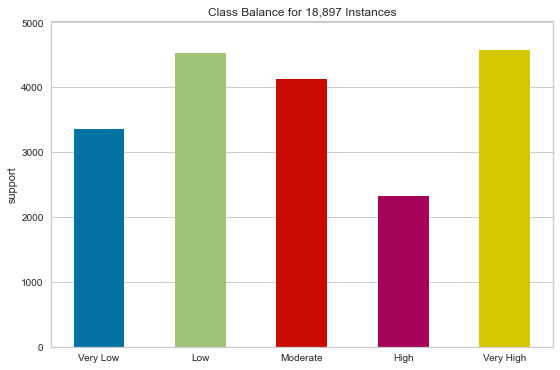

<AxesSubplot:title={'center':'Class Balance for 18,897 Instances'}, ylabel='support'>

In [6]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["Very Low", "Low", "Moderate", "High", "Very High"])

visualizer.fit(y)
visualizer.show()

In [36]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15117, 147) (15117,)
(3780, 147) (3780,)


In [37]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]



def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    model.fit(X, y, **kwargs)
    
    expected = y
    predicted = model.predict(X) 
    
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [38]:

def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['False', 'True'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

In [28]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

ValueError: Found input variables with inconsistent numbers of samples: [18896, 18897]